**This notebook visualizes annotations overlaid on top of the tissue and creates tissue mask files.**

In [1]:
# add ASAP path to sys to locate the multiresolutionimageinterface
import sys
sys.path.append('/opt/ASAP/bin')
# required libraries
import multiresolutionimageinterface as mir
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook

> NOTE: You can change the x,y -coordinates and filenames 

In [16]:
imagePath = './data/training/center_0/patient_004_node_4.tif'
maskPath = imagePath.replace('.tif', '_mask.tif')

# Pixel coordinates

# These coordinates have tumor in patient_004_node_4
x_center = 12711
y_center = 88778

# ...and these don't
#x_center = 12711
#y_center = 88578

# Fixed crop size
width = 256
height = 256

# Visualization scale for plotting
scale = 50
# Sample these levels, decreasing order
downsamples = [16,8,4,2,1]

reader = mir.MultiResolutionImageReader()
mr_image = reader.open(imagePath)
mr_mask = reader.open(maskPath)

This function returns tuple of original crops of images and tumor mask crops. The number of images in each list corresponds to level count. 

In [17]:
def getSamplesWithAnnotations(x_cent, y_cent):
    channels = 3
    imgs = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    masks = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    for i, ds_size in enumerate(downsamples):
        lev = mr_image.getBestLevelForDownSample(ds_size)
        ds = mr_image.getLevelDownsample(lev)
        imgs[i] = mr_image.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
        masks[i] = mr_mask.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
    return imgs, masks

Functions for deciding the crop's label and other attributes

In [18]:
def isTumor(mask_level_0):
    return (mask_level_0.max() > 0)

def tumorPercentage(mask_level_0):
    area = mask_level_0.shape[0] * mask_level_0.shape[1]
    tumorPixels = 0
    channels = 3
    for p in mask_level_0.flatten():
        tumorPixels = tumorPixels + 1 if p == 1 else tumorPixels
    return tumorPixels / (area * channels)

**Plot**

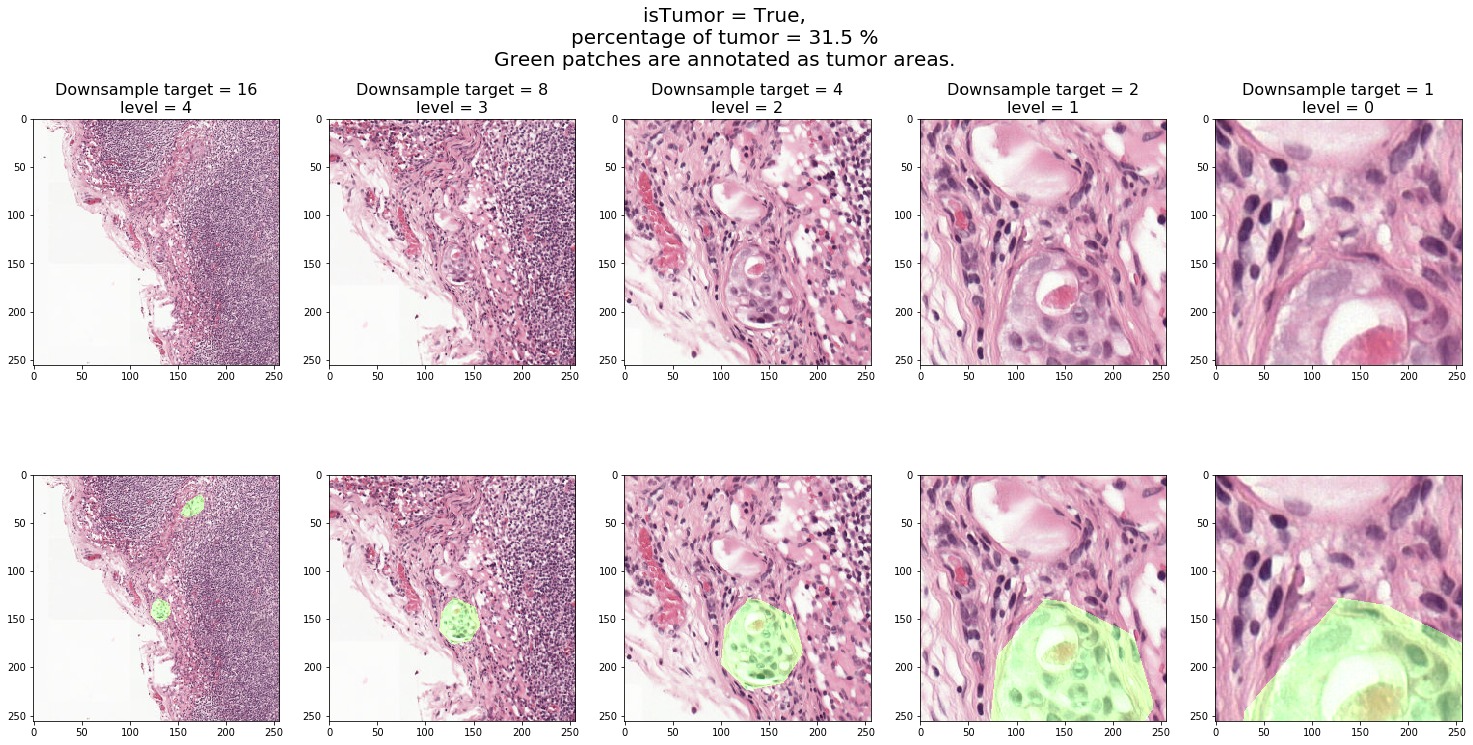

In [19]:
f, ax = plt.subplots(2,len(downsamples),figsize = (len(downsamples) * width / scale, int(2.5 * height / scale)))

imgs, masks = getSamplesWithAnnotations(x_cent=x_center,
                                        y_cent=y_center)
# check label from the lowest level
lbl = isTumor(masks[len(downsamples) - 1])
tumorPrc = tumorPercentage(masks[len(downsamples) - 1])
f.suptitle('isTumor = {0},\npercentage of tumor = {1} %\nGreen patches are annotated as tumor areas.'.format(lbl, int(tumorPrc * 1000)/10), fontsize=20)
alpha = 0.5

for i, ds_size in enumerate(downsamples):
    level = mr_image.getBestLevelForDownSample(ds_size)
    ax[0,i].imshow(imgs[i])
    
    # colorize
    mask_color = masks[i] * 200
    mask_color[:,:,[0,2]] = 0
    
    # create alpha channel to add to both images
    alpha_c = np.ones((mask_color.shape[0], mask_color.shape[1], 1), dtype=np.int32) * 255
    mask_color = np.concatenate([mask_color, alpha_c], axis=2)
    alpha_image = np.concatenate([imgs[i], alpha_c], axis=2)
    
    for x in range(mask_color.shape[0]):
        for y in range(mask_color.shape[1]):
            mask_color[x, y, 3] = 255 if mask_color[x, y, 2] == 1 else 0
            
    alpha_image = cv2.addWeighted(mask_color, 0.5, alpha_image, 1, 0)
    alpha_image = alpha_image.clip(min=0,max=255)
    ax[1,i].imshow(alpha_image)
    ax[0,i].set_title('Downsample target = {0}\nlevel = {1}'.format(ds_size, level), fontsize=16)

Out of the downsampling factors, 1 (level 0) and 8 (level 3) seems interesting. DS 1 gives a close zoom view while DS 8 displays the surroundings in a scale that could present useful information to a tumor classifier.  

# Tissue masking

Compare different methods. Downsampling of 16 (corresponds to level 4 here) seems like a reasonable size for masking. Out of graylevel, saturation, lightness, and value, saturation is works visually the best for separating tissue and glass.

In [6]:
## This function is adapted from a digital pathology pipeline code of Mikko Tukiainen
def make_tissue_mask(slide, mask_level = 4, morpho=None, morpho_kernel_size=5, morpho_iter=1, median_filter=False, return_original = False): 
    ''' make tissue mask
        return tissue mask array which has tissue locations (pixel value 0 -> empty, 255 -> tissue)
    Args:
        slide (MultiResolutionImage): MultiResolutionImage slide to process
        mask_level (int): defines the level of zoom at which the mask be created (default 4)
        morpho (cv2.MORPHO): OpenCV morpho flag, Cv2.MORPHO_OPEN or Cv2.MORPHO_CLOSE (default None)
        morpho_kernel_size (int): kernel size for morphological transformation (default 5)
        morpho_iter (int): morphological transformation iterations (default=1)
        median_filtern (bool): Use median filtering to remove noise (default False)
        return_original (bool): return also the unmasked image
    '''
    
    ## Read the slide
    ds = slide.getLevelDownsample(mask_level)
    original_tissue = slide.getUCharPatch(0,
                                         0,
                                         int(slide.getDimensions()[0] / float(ds)),
                                         int(slide.getDimensions()[1] / float(ds)),
                                         mask_level)
    
    ## Determine the mask
    tissue_mask = cv2.cvtColor(np.array(original_tissue), cv2.COLOR_RGBA2RGB)
    tissue_mask = cv2.cvtColor(tissue_mask, cv2.COLOR_BGR2HSV)
    tissue_mask = tissue_mask[:, :, 1]
    _, tissue_mask = cv2.threshold(tissue_mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    if morpho is not None:
        kernel = np.ones((morpho_kernel_size,morpho_kernel_size), np.uint8)
        tissue_mask = cv2.morphologyEx(tissue_mask, morpho, kernel, iterations = morpho_iter)
        
    if median_filter:
        tissue_mask = cv2.medianBlur(tissue_mask, 15)
    
    tissue_mask = np.array(tissue_mask, dtype=np.uint8)

    if return_original:
        return tissue_mask, original_tissue
    else:
        return tissue_mask

### Tissue sampling
Overlapped grid sampling.

In [7]:
def sample_centers(tissue_mask, mask_downscale=16, sample_side=256, focus_width_percentage=0.25, padding_percentage=0.01):
    mask_width, mask_height = tissue_mask.shape[:2]
    side = sample_side / mask_downscale
    padding_width = mask_width*padding_percentage
    padding_height = mask_height*padding_percentage
    half_focus = int(sample_side*focus_width_percentage / mask_downscale)
    sample_centers = []
    
    for i in range(int(mask_width // side)):
        for j in range(int(mask_height // side)):
            for sub_shift in [0, 0.5]:
                x = int((i+sub_shift) * side)
                y = int((j+sub_shift) * side)
                min_x = int(max(0, x - half_focus))
                max_x = int(min(x + half_focus, mask_width - 1))
                min_y = int(max(0, y - half_focus))
                max_y = int(min(y + half_focus, mask_height - 1))
                
                if(min_x < padding_width or max_x > mask_width-padding_width): continue
                if(min_y < padding_height or max_y > mask_height-padding_height): continue
                
                if(tissue_mask[min_x:max_x, min_y:max_y].sum() > 0):
                    sample_centers.append(np.array([x, y]))
                    
    # undo mask downscale to coordinates
    sample_centers = np.array(sample_centers) * mask_downscale
    return sample_centers

Try different methods for producing tissue masks.

In [8]:
comparison_masks = []
comparison_mask_titles = []

otsu_mask, original_image = make_tissue_mask(mr_image, 
                                             mr_image.getBestLevelForDownSample(16), 
                                             return_original=True)

# replace black "empty" areas with white for cleaner visualization
#original_image[np.where((original_image < [18,18,18]).all(axis = 2))] = [252,252,252]    

comparison_mask_titles.append('Original tissue')
comparison_masks.append(original_image)
comparison_mask_titles.append('Otsu mask')
comparison_masks.append(otsu_mask)

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=1)')
comparison_masks.append(make_tissue_mask(mr_image, 
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=1))

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=2)')
comparison_masks.append(make_tissue_mask(mr_image, 
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=2))

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=2)\nMedian filter')
comparison_masks.append(make_tissue_mask(mr_image,
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=2,
                                         median_filter=True))

CPU times: user 1min 27s, sys: 10.2 s, total: 1min 37s
Wall time: 16.3 s
Parser   : 303 ms


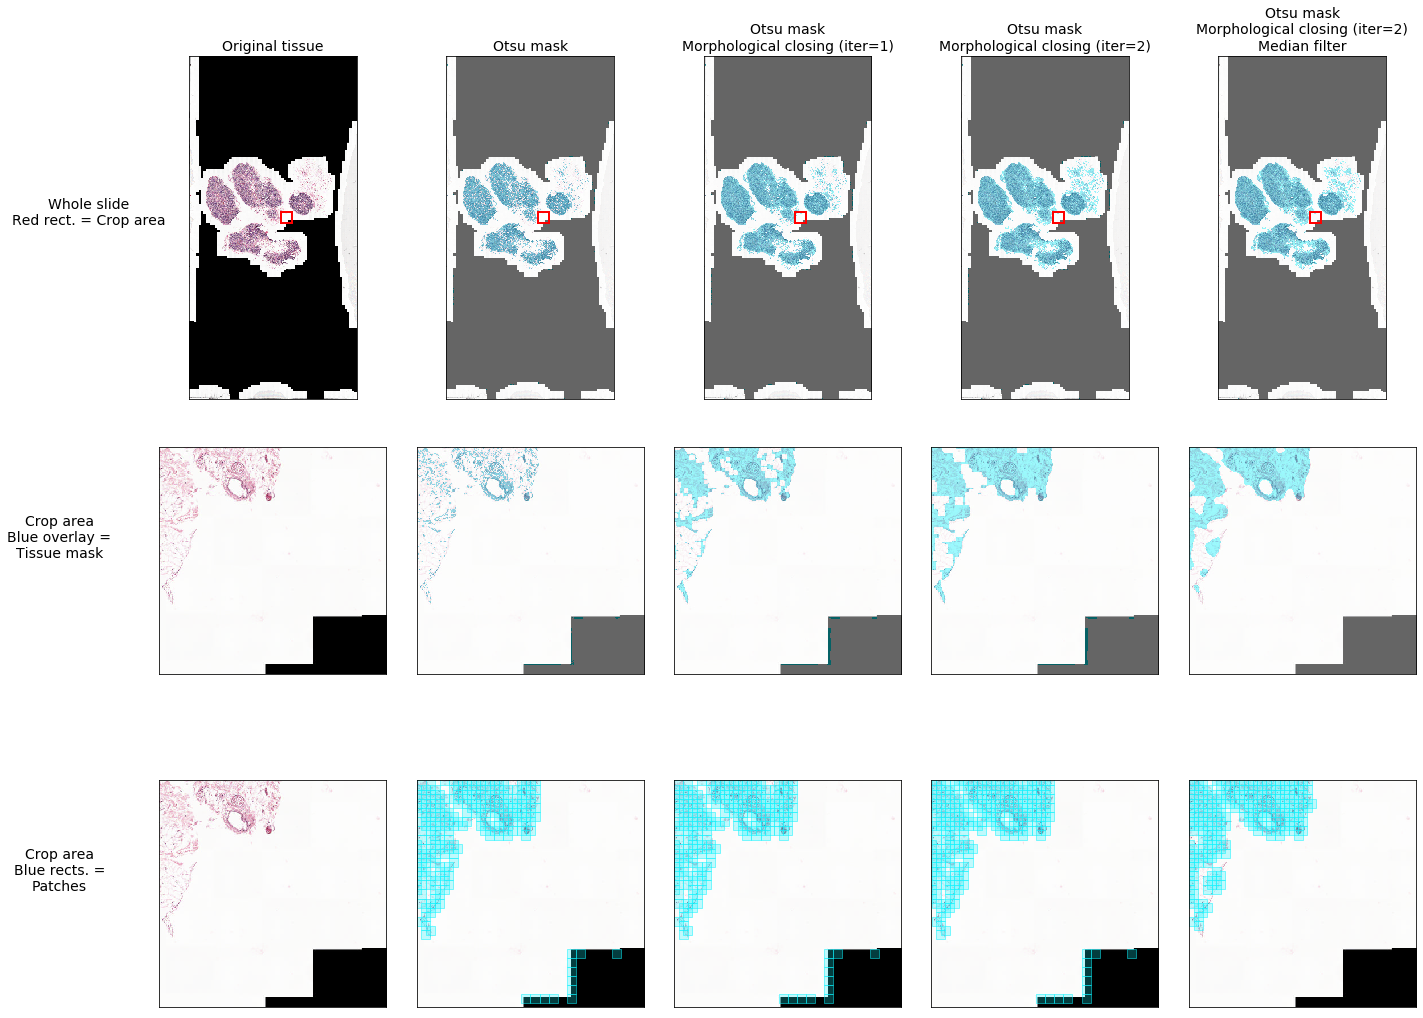

In [9]:
%%time
import matplotlib.patches as patches

# colormap for mask
from matplotlib import cm
from matplotlib.colors import ListedColormap
blues = cm.get_cmap('Blues', 256)
lightblue = blues(np.linspace(0, 1, 256))
lightblue[:100] = np.array([256/256,256/256,256/256,1])
turquoise = np.array([13/256,244/255,256/256,1])
turquoise_transparent = np.array([13/256,244/255,256/256,0.25])
lightblue[100:] = turquoise

f, ax = plt.subplots(3,len(comparison_masks),figsize=(20,15))
crop_x1 = 3300
crop_x2 = 3700
crop_y1 = 5600
crop_y2 = 6000
level_0_size = 256 / 16
fontsize_sz = 14
cmp = ListedColormap(lightblue)
alphaTissue = 1
alphaMask = 0.4

ax[0,0].imshow(comparison_masks[0], cmap=cmp)
ax[1,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)
ax[2,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)

for i in range(len(comparison_masks)):
    # draw first row
    if (i != 0):
        ax[0,i].imshow(comparison_masks[0], cmap=cmp, alpha=alphaTissue)
        ax[0,i].imshow(comparison_masks[i], cmap=cmp, alpha=alphaMask)
    ax[0,i].set_title(comparison_mask_titles[i], fontsize=fontsize_sz)
    crop_rect = patches.Rectangle((crop_x1,
                                   crop_y1),
                                  crop_x2-crop_x1,
                                  crop_y2-crop_y1,
                                  linewidth=2,
                                  edgecolor='r',
                                  facecolor='none')
    ax[0,i].add_patch(crop_rect)
    
    # draw second row
    if (i != 0):
        ax[1,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaTissue)
        ax[1,i].imshow(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaMask)
    
    # draw third row
    if (i != 0):
        sample_c_pts = sample_centers(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2],
                                      mask_downscale=1,
                                      sample_side=level_0_size,
                                      padding_percentage=0)
        ax[2,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=1)
        for pt in sample_c_pts:
            window_rect = patches.Rectangle((pt[1] - (level_0_size)/2,
                                             pt[0] - (level_0_size)/2),
                                            level_0_size,
                                            level_0_size,
                                            linewidth=0.5,
                                            edgecolor=turquoise,
                                            facecolor=turquoise_transparent)
            ax[2,i].add_patch(window_rect)
    
    # hide ticks
    for j in range(3):
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
ax[0,0].set_ylabel('Whole slide\nRed rect. = Crop area', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[1,0].set_ylabel('Crop area\nBlue overlay =\nTissue mask', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[2,0].set_ylabel('Crop area\nBlue rects. =\nPatches', fontsize=fontsize_sz, rotation=0, labelpad=100)
plt.tight_layout()

Based on this visualization, saturation-space Otsu threshold + 2 times morphological closing + median filtering produces dense enough sampling and still ignores small isolated tissue parts. This is used for creating the tissue masks.  

Lets see how the sampling locations look on the whole slide level.

CPU times: user 1min 7s, sys: 8.05 s, total: 1min 15s
Wall time: 31.2 s


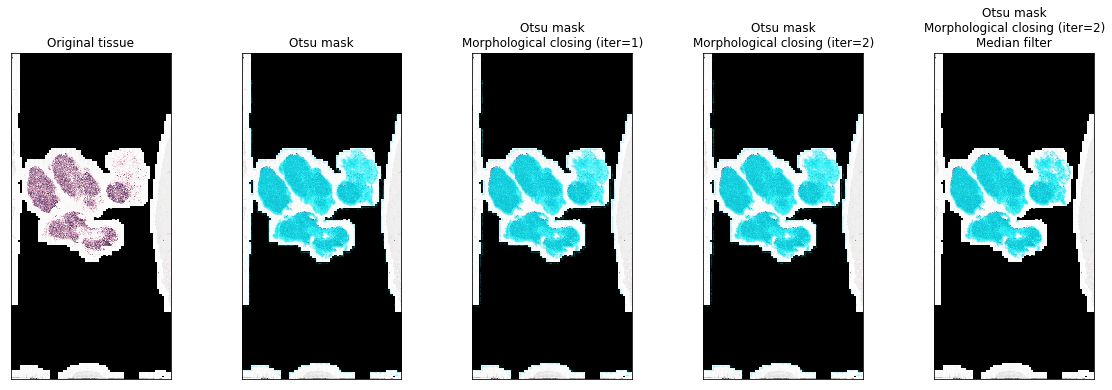

In [11]:
%%time
fontsize_sz = 12
f, ax = plt.subplots(1,len(comparison_masks),figsize=(20,6))
for i in range(len(comparison_masks)):
    ax[i].imshow(comparison_masks[0], cmap=cmp)
    ax[i].set_title(comparison_mask_titles[i], fontsize=fontsize_sz)
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    if (i>0):
        sample_c_pts = sample_centers(comparison_masks[i],
                                              mask_downscale=1,
                                              sample_side=level_0_size)

        ax[i].scatter(sample_c_pts[:,1], sample_c_pts[:,0], s=0.2, color=turquoise_transparent, alpha=0.1)

## Create tissue masks for each slide

In [12]:
dirData = 'data/training/'
ImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirData):
    for file in f:
        if '.tif' in file and 'mask' not in file:
            ImageFiles.append(os.path.join(r, file))

In [14]:
def CreateTissueMask(tifPath):
    
    # get only the name without dir or file suffix
    fileNamePart = tifPath.replace('.tif','').replace(dirData, "")
    
    # Skip if this mask is already found
    maskPath = tifPath.replace('.tif', '_tissue_mask_ds16.npy')
    if (os.path.isfile(maskPath)):
        print('Info - Tissue mask file of {0} already exists - skipping'.format(tifPath))
        return
    
    # create tissue mask
    mr_image = reader.open(tifPath)
    if(mr_image is None):
        print('Warning - Could not read {0} - skipping'.format(tifPath))
        return
    tissue_mask = make_tissue_mask(mr_image,
                                   mr_image.getBestLevelForDownSample(16), 
                                   morpho=cv2.MORPH_CLOSE,
                                   morpho_kernel_size=7,
                                   morpho_iter=2,
                                   median_filter=True)
    # tissue_mask is a binary array dtype.uint8  (16 times downsampled)
    np.save(maskPath, tissue_mask)

In [15]:
for f in tqdm_notebook(ImageFiles, 'Creating tissue masks...'):
    print('WSI: ' + f)
    CreateTissueMask(f)

WSI: data/training/center_0/patient_000_node_0.tif
WSI: data/training/center_0/patient_000_node_1.tif
WSI: data/training/center_0/patient_000_node_2.tif
WSI: data/training/center_0/patient_000_node_3.tif
WSI: data/training/center_0/patient_000_node_4.tif
WSI: data/training/center_0/patient_001_node_0.tif
WSI: data/training/center_0/patient_001_node_1.tif
WSI: data/training/center_0/patient_001_node_2.tif
WSI: data/training/center_0/patient_001_node_3.tif
WSI: data/training/center_0/patient_001_node_4.tif
WSI: data/training/center_0/patient_002_node_0.tif
WSI: data/training/center_0/patient_002_node_1.tif
WSI: data/training/center_0/patient_002_node_2.tif
WSI: data/training/center_0/patient_002_node_3.tif
WSI: data/training/center_0/patient_002_node_4.tif
WSI: data/training/center_0/patient_003_node_0.tif
WSI: data/training/center_0/patient_003_node_1.tif
WSI: data/training/center_0/patient_003_node_2.tif
WSI: data/training/center_0/patient_003_node_3.tif
WSI: data/training/center_0/pat

WSI: data/training/center_1/patient_024_node_1.tif
WSI: data/training/center_1/patient_024_node_2.tif
WSI: data/training/center_1/patient_024_node_3.tif
WSI: data/training/center_1/patient_024_node_4.tif
WSI: data/training/center_1/patient_025_node_0.tif
WSI: data/training/center_1/patient_025_node_1.tif
WSI: data/training/center_1/patient_025_node_2.tif
WSI: data/training/center_1/patient_025_node_3.tif
WSI: data/training/center_1/patient_035_node_2.tif
WSI: data/training/center_1/patient_035_node_3.tif
WSI: data/training/center_1/patient_035_node_4.tif
WSI: data/training/center_1/patient_029_node_0.tif
WSI: data/training/center_1/patient_029_node_1.tif
WSI: data/training/center_1/patient_029_node_2.tif
WSI: data/training/center_1/patient_029_node_3.tif
WSI: data/training/center_1/patient_029_node_4.tif
WSI: data/training/center_1/patient_026_node_0.tif
WSI: data/training/center_1/patient_026_node_1.tif
WSI: data/training/center_1/patient_026_node_2.tif
WSI: data/training/center_1/pat

WSI: data/training/center_3/patient_072_node_2.tif
WSI: data/training/center_3/patient_072_node_3.tif
WSI: data/training/center_3/patient_072_node_4.tif
WSI: data/training/center_3/patient_079_node_0.tif
WSI: data/training/center_3/patient_079_node_1.tif
WSI: data/training/center_3/patient_079_node_2.tif
WSI: data/training/center_3/patient_079_node_3.tif
WSI: data/training/center_3/patient_079_node_4.tif
WSI: data/training/center_3/patient_073_node_0.tif
WSI: data/training/center_3/patient_073_node_1.tif
WSI: data/training/center_3/patient_073_node_2.tif
WSI: data/training/center_3/patient_073_node_3.tif
WSI: data/training/center_3/patient_073_node_4.tif
WSI: data/training/center_3/patient_068_node_0.tif
WSI: data/training/center_3/patient_068_node_1.tif
WSI: data/training/center_3/patient_068_node_2.tif
WSI: data/training/center_3/patient_068_node_3.tif
WSI: data/training/center_3/patient_068_node_4.tif
WSI: data/training/center_3/patient_070_node_0.tif
WSI: data/training/center_3/pat

WSI: data/training/center_4/patient_080_node_3.tif
WSI: data/training/center_4/patient_080_node_4.tif
WSI: data/training/center_4/patient_090_node_0.tif
WSI: data/training/center_4/patient_090_node_1.tif
WSI: data/training/center_4/patient_090_node_2.tif
WSI: data/training/center_4/patient_090_node_3.tif
WSI: data/training/center_4/patient_090_node_4.tif
WSI: data/training/center_4/patient_095_node_0.tif
WSI: data/training/center_4/patient_095_node_1.tif
WSI: data/training/center_4/patient_095_node_2.tif
WSI: data/training/center_4/patient_095_node_3.tif
WSI: data/training/center_4/patient_095_node_4.tif
WSI: data/training/center_4/patient_085_node_0.tif
WSI: data/training/center_4/patient_085_node_1.tif
WSI: data/training/center_4/patient_085_node_2.tif
WSI: data/training/center_4/patient_085_node_3.tif
WSI: data/training/center_4/patient_085_node_4.tif

